In [1]:
import os
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from datetime import datetime, date
import pacmap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import plotly.express as px
from kneed import KneeLocator
import distinctipy
import pickle

def compute_age(date):
    if not date:
        return None
    date = datetime.strptime(date, "%Y-%m-%d").date()
    today = date.today()
    # check if this year's birthday has passed:
    offset = int((today.month, today.day) < (date.month, date.day))

    return today.year - date.year - offset
    
random_state = 42
np.random.seed(random_state)
colors = distinctipy.get_colors(20)

# Check and create figure directories
model_list = ["kmeans", "gmm", "dbscan", "spectral_rbf", "spectral_knn"]
fig_dir = "figures"
for model in model_list:
    if not os.path.exists(f"{fig_dir}/{model}"):
        os.mkdir(f"{fig_dir}/{model}")
if not os.path.exists(f"{fig_dir}/general"):
    os.mkdir(f"{fig_dir}/general")

# Load Data
clustering_df = pd.read_csv("../data/clustering_common_variables_la_fe.csv")
clustering_df = clustering_df.set_index(["protocol_id", "patient_id"])
metadata_df = pd.read_csv("../data/clustering_metadata_la_fe.csv", index_col=0)
metadata_df["age"] = metadata_df["birth_date"].apply(compute_age)

# Load models
model_result_dict = {}
for model in model_list:
    with open(f"model_results/{model}_results.pickle", "rb") as f:
        model_result_dict[model] = pickle.load(f)

In [2]:
# Add clustering label columns
for model in model_list:
    labels = model_result_dict[model]["labels"]
    metadata_df[f"{model}_label"] = labels 

In [3]:
# Standardize data
var_list = list(clustering_df.columns)
X = clustering_df.to_numpy()
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

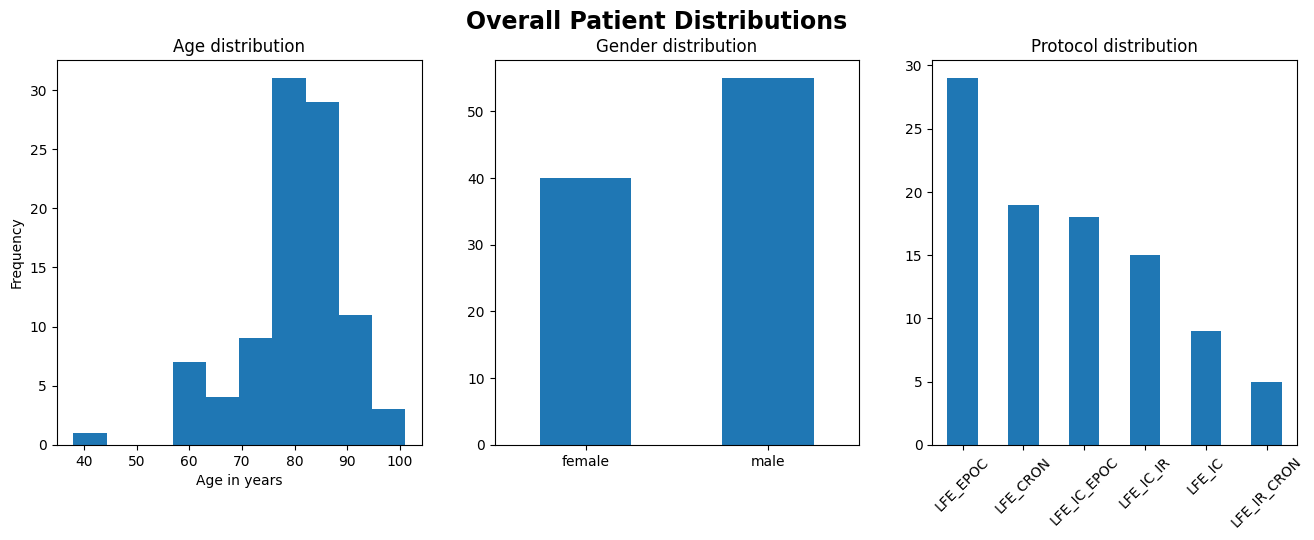

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
metadata_df.age.plot(kind="hist", ax=ax1)
ax1.set_xlabel("Age in years")
ax1.set_title("Age distribution")
metadata_df.gender.value_counts().sort_values().plot(kind='bar', ax=ax2)
ax2.set_xticklabels(metadata_df.gender.unique(), rotation = 0)
ax2.set_title("Gender distribution")
metadata_df.protocol_name.value_counts().plot(kind='bar', ax=ax3)
ax3.set_xticklabels(metadata_df.protocol_name.unique(), rotation = 45)
ax3.set_title("Protocol distribution")
fig.suptitle("Overall Patient Distributions", fontsize=17, fontweight="bold")
fig.savefig(f"{fig_dir}/general/distributions.png")

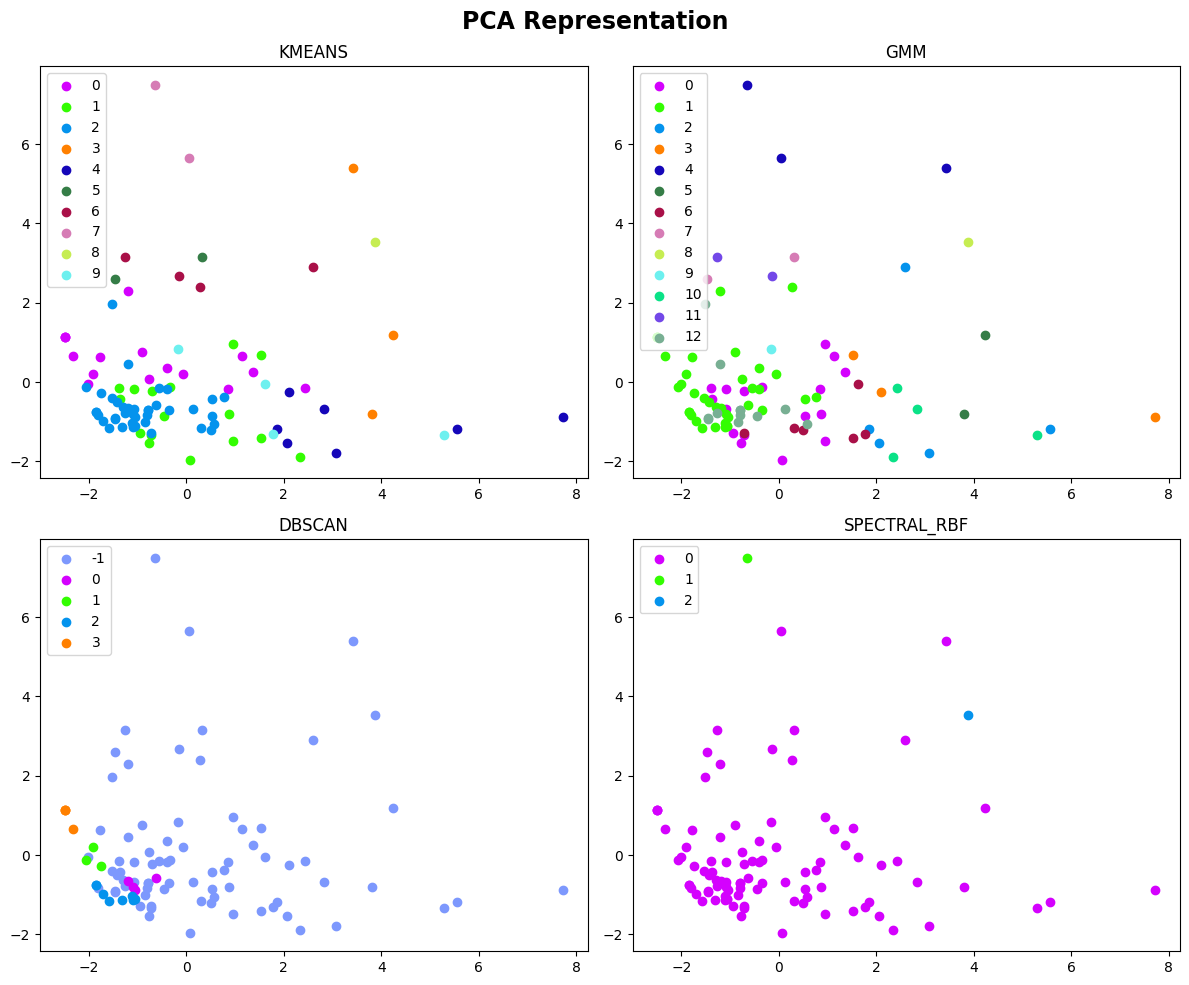

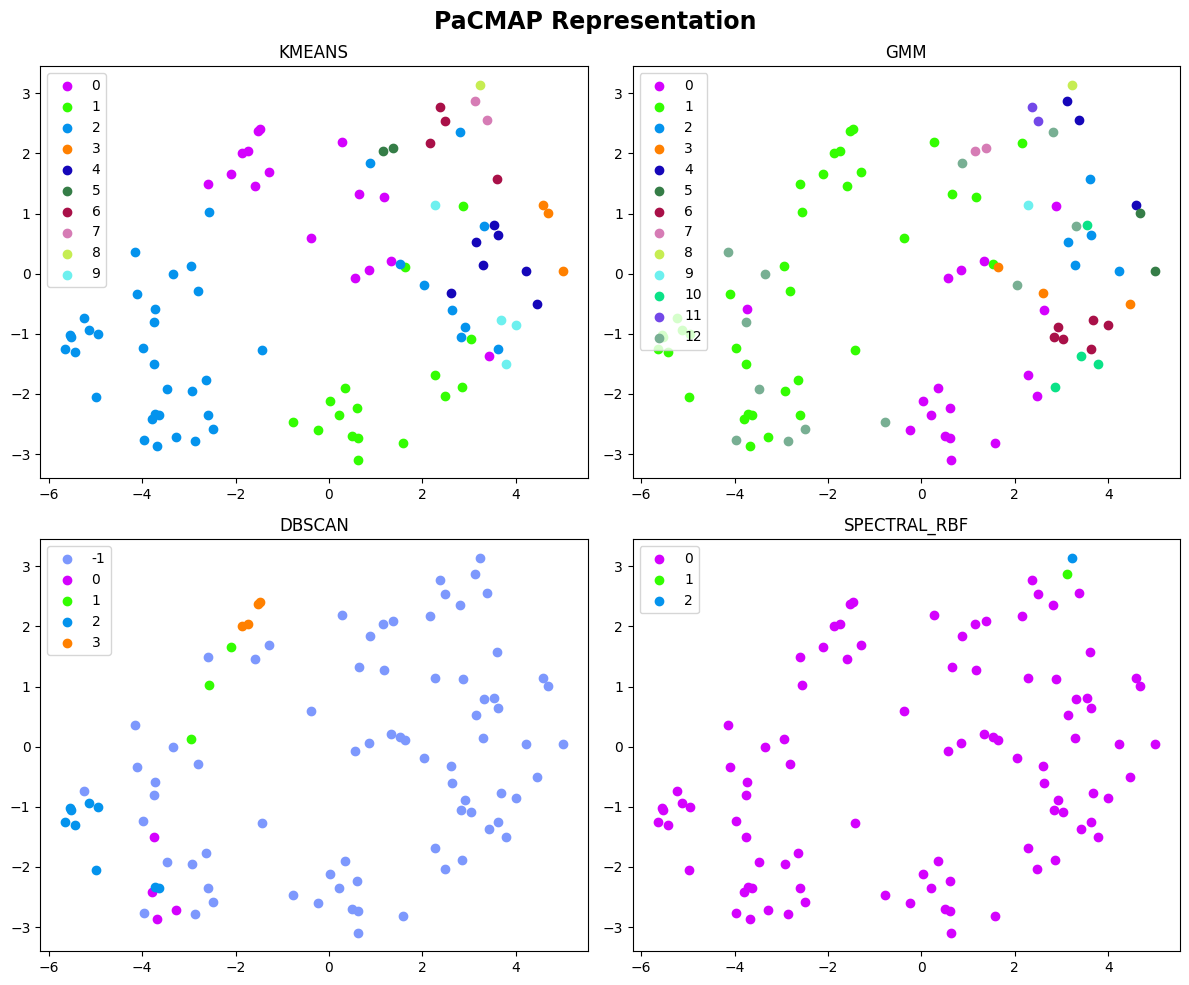

In [5]:
pca_trans = PCA(n_components=2)
X_norm_pca = pca_trans.fit_transform(X_std)

pacmap_trans = pacmap.PaCMAP()
X_norm_pacmap = pacmap_trans.fit_transform(X_std)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), tight_layout=True)
for i, ax in enumerate(axs.reshape(-1)):
    model = model_list[i]
    labels = model_result_dict[model]["labels"]
    for l in np.unique(labels):
        ax.scatter(
            X_norm_pca[labels == l, 0],
            X_norm_pca[labels == l, 1],
            color=colors[l],
            label = l)
    ax.legend(loc=2)
    ax.set_title(f"{model.upper()}")
fig.suptitle("PCA Representation", fontsize=17, fontweight="bold")
fig.savefig(f"{fig_dir}/general/pca_representations.png")

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), tight_layout=True)
for i, ax in enumerate(axs.reshape(-1)):
    model = model_list[i]
    labels = model_result_dict[model]["labels"]
    for l in np.unique(labels):
        ax.scatter(
            X_norm_pacmap[labels == l, 0],
            X_norm_pacmap[labels == l, 1],
            color=colors[l],
            label = l)
    ax.legend(loc=2)
    ax.set_title(f"{model.upper()}")
fig.suptitle("PaCMAP Representation", fontsize=17, fontweight="bold")
fig.savefig(f"{fig_dir}/general/pacmap_representations.png")

In [6]:
for model in model_list[:4]:
    labels = model_result_dict[model]["labels"]
    unique_labels = np.unique(labels)
    for i, label in enumerate(unique_labels):
        cluster_df = metadata_df[metadata_df[f"{model}_label"] == label]
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
        cluster_df.age.plot(kind="hist", ax=ax1)
        ax1.set_xlabel("Age in years")
        ax1.set_title("Age distribution")
        cluster_df.gender.value_counts().sort_values().plot(kind='bar', ax=ax2)
        ax2.set_xticklabels(cluster_df.gender.unique(), rotation = 0)
        ax2.set_title("Gender distribution")
        cluster_df.protocol_name.value_counts().plot(kind='bar', ax=ax3)
        ax3.set_xticklabels(cluster_df.protocol_name.unique(), rotation = 45)
        ax3.set_title("Protocol distribution")
        fig.suptitle(f"Cluster {label} (size = {sum(labels == label)})", fontsize=17, fontweight="bold")
        fig.savefig(f"{fig_dir}/{model}/cluster_{label}_distributions.png")
        plt.close()

In [7]:
# K-Means Radar Plots
W = 5
n_clusters = model_result_dict["kmeans"]["params"]["n_clusters"]
labels = model_result_dict["kmeans"]["labels"]
centroids_norm = model_result_dict["kmeans"]["weights"]
unique_labels = np.unique(labels)
for i, label in enumerate(unique_labels):
    top_W_idx = np.argpartition(centroids_norm[i, :], -W)[-W:]
    top_W_vals = centroids_norm[i, top_W_idx]
    top_W_vars = [var_list[i] for i in top_W_idx]
    fig = px.line_polar(
        r=top_W_vals, 
        theta=top_W_vars, 
        line_close=True, 
        title=f"Cluster {i}, population = {sum(labels == label)}")
    fig.update_traces(fill='toself')
    fig.write_image(f"{fig_dir}/kmeans/cluster_weights_{label}.png")

In [12]:
# GMM Radar Plots
W = 5
labels = model_result_dict["gmm"]["labels"]
centroids_norm = model_result_dict["gmm"]["means"]
unique_labels = np.unique(labels)
for i, label in enumerate(unique_labels):
    top_W_idx = np.argpartition(centroids_norm[i, :], -W)[-W:]
    top_W_vals = centroids_norm[i, top_W_idx]
    top_W_vars = [var_list[i] for i in top_W_idx]
    fig = px.line_polar(
        r=top_W_vals, 
        theta=top_W_vars, 
        line_close=True, 
        title=f"Cluster {i}, population = {sum(labels == label)}")
    fig.update_traces(fill='toself')
    fig.write_image(f"{fig_dir}/gmm/cluster_weights_{label}.png")